In [95]:
import os
import sys
from glob import glob
import yaml
import ROOT
import pandas as pd
import root_pandas as rpd
from sklearn.model_selection import train_test_split
import xgboost as xgb
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
from collections import defaultdict
import ROOT
import copy

In [106]:
with open('config_test_MX20_DL.yaml','r') as conf:
    config = yaml.safe_load(conf)

mainkeys    = list(config.keys())
tag         = config.get('Tag')
pwd         = os.getcwd()
tagdir      = os.path.join(pwd,tag)

maintree    = config.get('intree')
infiledict  = config.get('infiles')
lumi = config.get('Lumi')
print(f'Lumi : {lumi} pb-1')
usenorm = config.get('UseNormForPlots')
#print(infiledict)
clskeys = list(infiledict.keys())
#print(clskeys)
featurelist = config.get('features') 

signaldict = infiledict.get('Signal')
backgrounddict = infiledict.get('Background')
restbackgrounddict = infiledict.get('RestBackground')


dfs_dict = dict()
for key, val in signaldict.items():
    df_item = rpd.read_root(val[0], key=maintree)[featurelist]
    df_item['tag'] = 1
    xsec = val[1]
    nEvents = val[2]
    label = val[3]
    dfs_dict[key] = [df_item, xsec, nEvents, label]

for key, val in backgrounddict.items():
    df_item = rpd.read_root(val[0], key=maintree)[featurelist]
    df_item['tag'] = 0
    xsec = val[1]
    nEvents = val[2]
    label = val[3]
    dfs_dict[key] = [df_item, xsec, nEvents, label]
'''
for key, val in restbackgrounddict.items():
    df_item = rpd.read_root(val[0], key=maintree)[featurelist]
    df_item['tag'] = 0
    xsec = val[1]
    nEvents = val[2]
    label = val[3]
    dfs_dict[key] = [df_item, xsec, nEvents, label]
'''    
#print(dfs_dict)

Lumi : 300000 pb-1


In [107]:
model_xgb = xgb.Booster()
model_xgb.load_model(os.path.join(tagdir,'XGB_test.json'))

In [108]:
labelhistdict = {}
labelhistdictforplot = defaultdict(list)
nbins = 100
xmin  = 0.0
xmax  = 1.0
for sample, info in dfs_dict.items():
    #print(sample, info[3])
    pdtonp = info[0].to_numpy()
    #print(pdtonp.shape)
    X_np = pdtonp[:,:pdtonp.shape[1]-1]
    #print(X_np.shape)
    Y_np = pdtonp[:,-1]
    #print(Y_np.shape)
    D_xgb = xgb.DMatrix(X_np, label = Y_np, feature_names = featurelist)
    preds = model_xgb.predict(D_xgb, ntree_limit=model_xgb.best_iteration)
    #preds = model_xgb.predict(D_xgb)
    #print(preds)
    hname = 'pred_hist_'+sample
    hname = ROOT.TH1F(hname, "", nbins, xmin, xmax)
    for item in preds:
        hname.Fill(item)
    #print(f'sample : {sample}, nRawEvents : {hname.Integral()}')
    hname.Scale(info[1]*lumi/info[2])
    #print(f' -- nLumiScaledEvents : {hname.Integral()}')
    labelhistdict[sample] = hname # for individual process 
    labelhistdictforplot[info[3]].append(hname)
    hname.SetDirectory(0)
    
#print(labelhistdict)
#print(labelhistdictforplot)

# Get Significance

Significance at 70% signal efficiency : 0.128
Signal efficiency : (56, 0.798)
Bkg rejection : 0.575
bkg rej : 0.842
bkg rej : 0.733
bkg rej : 0.575
bkg rej : 0.301


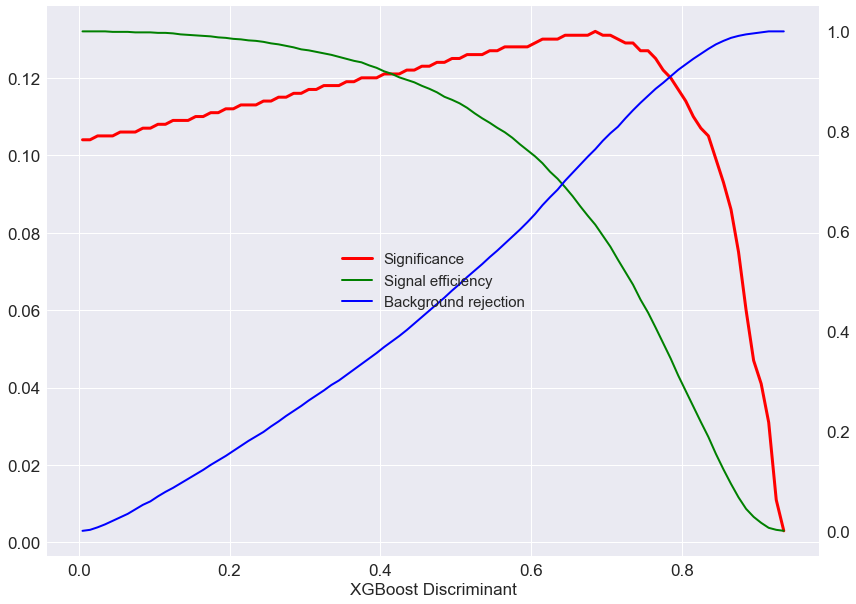

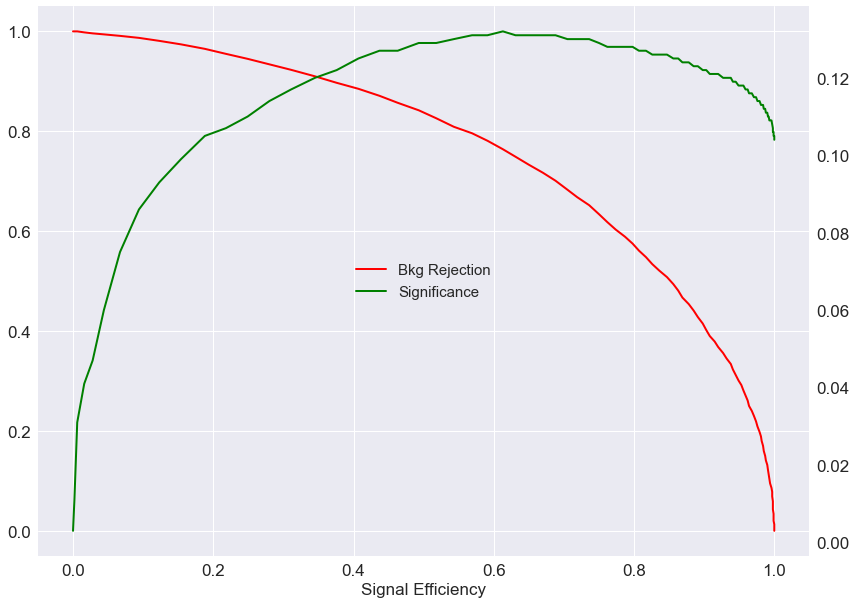

In [109]:
from math import sqrt
signifs = []
sig_effs = []
sig_purs = []
bkg_rejs = []
bdtscores = []
hsig = labelhistdict.get('muta_lnu')
nSigEvents = hsig.Integral()
nBkgEvents = 0.0
for i in range(nbins):
    ibin = i+1
    #print(f'bin > {ibin}')
    nsig = hsig.Integral(ibin, nbins)
    #print(f'nSignal : {nsig}')
    nbkg = 0
    #print('Bkg -->')
    for j,(key, val) in enumerate(labelhistdict.items()):
        if j == 0 : 
            continue
        if i == 0 :
            nBkgEvents += val.Integral() 
        nbkg_ = val.Integral(ibin, nbins)
        #print(f' >>--- proc : {key} --> {nbkg_}')
        nbkg += nbkg_
    if nsig+nbkg == 0:
        continue
    sig_eff = nsig/nSigEvents
    bkg_rej = 1 - nbkg/nBkgEvents
    sig_pur = nsig/(nsig + nbkg)
    signif = nsig/sqrt(nsig+nbkg)
    #print(f'total Bkg. {nbkg}')
    #print(f'BDT score : {hsig.GetBinCenter(ibin)} , Significance. {signif}\n')
    bdtscores.append(round(hsig.GetBinCenter(ibin),3))
    signifs.append(round(signif,3))
    sig_effs.append(round(sig_eff, 3))
    bkg_rejs.append(round(bkg_rej, 3))
    sig_purs.append(round(sig_pur, 3))
    
sigeff70p = min(enumerate(sig_effs), key=lambda x: abs(x[1]-0.8))
#sigeff70p_idx = np.argmin(np.abs(np.array(sig_effs)-))
bkgrejatsigeff70p = bkg_rejs[sigeff70p[0]]
signfcatsigeff70p = signifs[sigeff70p[0]]

print(f'Significance at 70% signal efficiency : {signfcatsigeff70p}')
print(f'Signal efficiency : {sigeff70p}')
print(f'Bkg rejection : {bkgrejatsigeff70p}')

_sigeff = sigeff70p[1]
_bkgrej = bkgrejatsigeff70p
_signif = signfcatsigeff70p
_score  = bdtscores[sigeff70p[0]]
#print(signifs, len(signifs))   
#print(bdtscores, len(bdtscores))

for seff in [0.5,0.65,0.8,0.95]:
    sigeff_temp = min(enumerate(sig_effs), key=lambda x: abs(x[1]-seff))
    print(f'bkg rej : {bkg_rejs[sigeff_temp[0]]}')
    
'''
plt.figure(figsize=(12,8.5))
plt.plot(bdtscores, signifs, lw=3)
plt.xlabel('XGBoost score', size=20)
plt.ylabel('Significance', size=20)
plt.title('s/sqrt(s+b) vs. BDT score', size=20)
plt.text(0.2, 2, f'max significance : {max(signifs)}\n at BDT_score : {bdtscores[signifs.index(max(signifs))]}', fontsize = 22)
plt.savefig(os.path.join(tagdir,'maxSignificance.png'),dpi=300)
plt.show()
'''
fig, ax = plt.subplots(figsize=(12,8.5))
#plt.grid(False)
ax = plt.gca()
l1,=ax.plot(bdtscores, signifs,  lw=3, color='red')
ax.grid(True)
ax.set_xlabel('XGBoost Discriminant', fontsize=17)
ax.tick_params(axis='x', labelsize=17)
ax.tick_params(axis='y', labelsize=17)

ax2 = ax.twinx()
l2,=ax2.plot(bdtscores, sig_effs, lw=2, color='green')
l3,=ax2.plot(bdtscores, bkg_rejs, lw=2, color='blue')
#l4,=ax2.plot(bdtscores, sig_purs, lw=2, color='magenta')
ax2.grid(False)
ax2.tick_params(axis='y', labelsize=17)

plt.legend([l1, l2, l3],
           ["Significance", "Signal efficiency", "Background rejection"], 
           loc='center',
           fontsize=15,
           fancybox=True,
           framealpha=0.5)
fig.tight_layout()
#plt.text(-0.3,0.8,f'max significance : {max(signifs)}\n at BDT_score : {bdtscores[signifs.index(max(signifs))]}\n sig eff : {sig_effs[signifs.index(max(signifs))]}\n bkg rej : {bkg_rejs[signifs.index(max(signifs))]}', fontsize = 22)
#plt.text(-0.3,0.3,f'significance at 80% sigeff: {_signif}\n at BDT_score : {_score}\n sig eff : {_sigeff}\n bkg rej : {_bkgrej}', fontsize = 22)
plt.savefig(os.path.join(tagdir,'maxSignificance.png'),dpi=300)
plt.show()

#plt.clf()
#plt.figure(figsize=(12,8.5))
#plt.plot(sig_effs, bkg_rejs,  lw=3)
#plt.plot(sig_effs, signifs, lw=3)
#plt.show()

fig, ax = plt.subplots(figsize=(12,8.5))
#plt.grid(False)
ax = plt.gca()
l1,=ax.plot(sig_effs, bkg_rejs,  lw=2, color='red')
ax.grid(True)
ax.set_xlabel('Signal Efficiency', fontsize=17)
ax.tick_params(axis='x', labelsize=17)
ax.tick_params(axis='y', labelsize=17)

ax2 = ax.twinx()
l2,=ax2.plot(sig_effs, signifs, lw=2, color='green')
ax2.grid(False)
ax2.tick_params(axis='y', labelsize=17)

plt.legend([l1, l2, l3, l4],
           ["Bkg Rejection", "Significance"], 
           loc='center',
           fontsize=15,
           fancybox=True,
           framealpha=0.5)
fig.tight_layout()
#plt.text(0.4,1.2,f'max significance : {max(signifs)}\n with \n sig eff : {sig_effs[signifs.index(max(signifs))]}\n bkg rej : {bkg_rejs[signifs.index(max(signifs))]}', fontsize = 22)
plt.savefig(os.path.join(tagdir,'ROCwithSignificance.png'),dpi=300)
plt.show()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2
Info in <TCanvas::Print>: png file /home/gsaha/Work/DelphesML/Project2/XGBoost/DL_MX_100_New/XGBoost_Discriminator.png has been created
Info in <TCanvas::Print>: png file /home/gsaha/Work/DelphesML/Project2/XGBoost/DL_MX_100_New/XGBoost_Discriminator_logy.png has been created


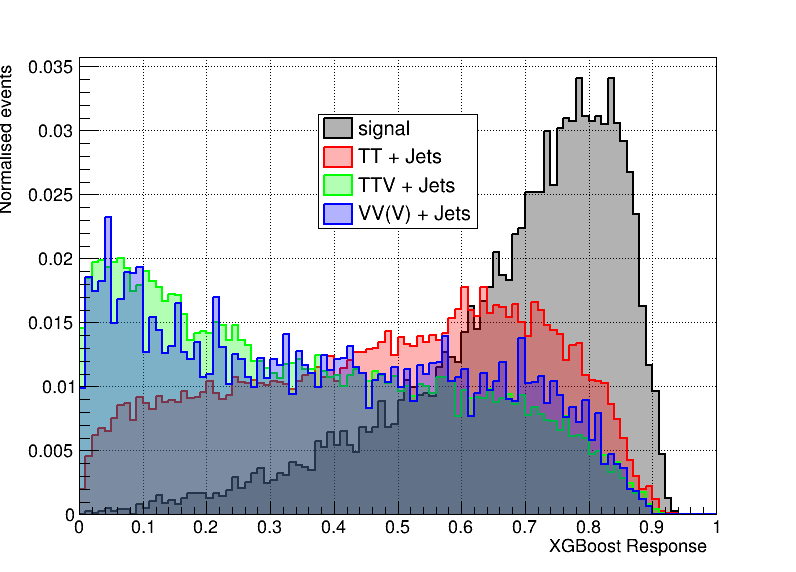

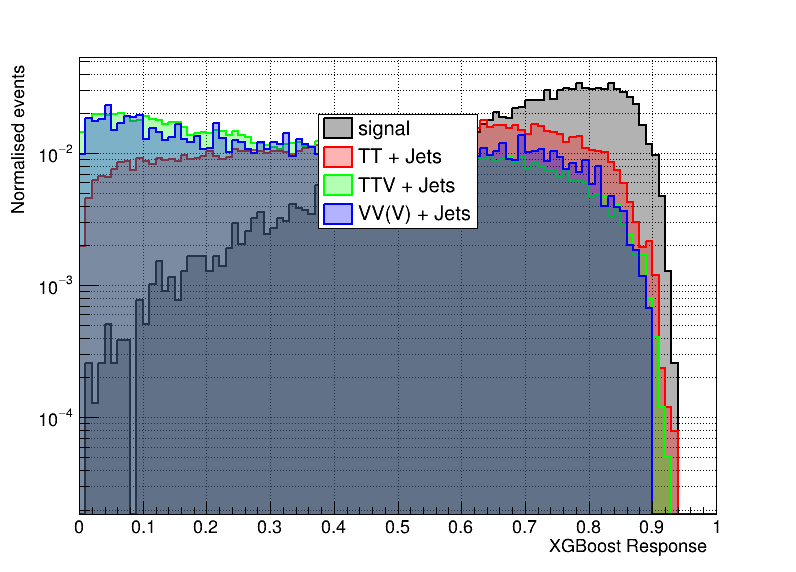

In [110]:
stack = ROOT.THStack()
canv  = ROOT.TCanvas('c','',800,600)
canv2 = ROOT.TCanvas('c2','',800,600)
#if usenorm:
#    ROOT.gPad.SetLogy()
legn  = ROOT.TLegend(0.4,0.6,0.6,0.8)
for idx, (label, histList) in enumerate(labelhistdictforplot.items()):
    if len(histList) == 0:
        continue
    hist = histList[0]
    if len(histList) > 1:
        for i,hist_ in enumerate(histList):
            if i == 0: continue
            hist.Add(hist_)
    if usenorm:
        hist_ = copy.deepcopy(hist)
        hist_.Scale(1/hist_.Integral())
    hist_.SetLineColor(idx+1)
    hist_.SetLineWidth(2)
    hist_.SetFillColorAlpha(idx+1,0.3);
    legn.AddEntry(hist_, label, 'f')
    stack.Add(hist_)

canv.cd()
stack.Draw('nostack hist')
stack.GetXaxis().SetTitle('XGBoost Response')
stack.GetYaxis().SetTitle('Normalised events')
legn.Draw()
canv.Update()
canv.SetGrid()
canv.SaveAs(os.path.join(tagdir,'XGBoost_Discriminator.png'))
canv.Draw()

canv2.cd()
canv2.SetLogy()
stack.Draw('nostack hist')
stack.GetXaxis().SetTitle('XGBoost Response')
stack.GetYaxis().SetTitle('Normalised events')
legn.Draw()
canv2.Update()
canv2.SetGrid()
canv2.SaveAs(os.path.join(tagdir,'XGBoost_Discriminator_logy.png'))
canv2.Draw()